# Регрессионный анализ: Kuiper.xls

- Корреляционный анализ; базовая линейная модель; выводы (коэффициенты, t-test, F-test);
- Диагностика: графики (scatter с линией регрессии, Residuals vs Fitted, Normal Q-Q, Residuals vs Leverage), проверка выбросов, influential observations (Cook's distance, leverage), VIF, тесты на гетероскедастичность, автокорреляцию, нормальность остатков;
- Stepwise (AIC) подбор модели и повторный анализ для улучшенной модели;
- Box–Cox трансформация отклика и анализ новой модели;
- Аналогичный анализ для датасета `cigarettes.txt` (модель: carbon monoxide ~ tar + nicotine + weight).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 11
sns.set(style='whitegrid')


## Kuiper.xls — загрузка и предобработка

In [2]:
kuiperDataFrame = pd.read_excel('../datasets/Kuiper.xls')
display(kuiperDataFrame.head())

def toFloatFromCommaSafe(x):
    try:
        if pd.isna(x):
            return np.nan
        s = str(x).strip().replace(',', '.')
        return float(s)
    except:
        return np.nan

numericCols = ['Price','Mileage','Cylinder','Liter','Cruise']
for col in numericCols:
    if col in kuiperDataFrame.columns:
        kuiperDataFrame[col] = kuiperDataFrame[col].apply(toFloatFromCommaSafe)
    else:
        print(f'Warning: column {col} not found in Kuiper.xls')

kuiperDataFrame = kuiperDataFrame.dropna(subset=['Price'])
kuiperDataFrame.describe()

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.036083,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.913140,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.170324,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1


,Price,Mileage,Cylinder,Liter,Doors,Cruise,Sound,Leather
count,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000
mean,21343.143767,19831.934080,5.268657,3.037313,3.527363,0.752488,0.679104,0.723881
std,9884.852801,8196.319707,1.387531,1.105562,0.850169,0.431836,0.467111,0.447355
min,8638.930895,266.000000,4.000000,1.600000,2.000000,0.000000,0.000000,0.000000
25%,14273.073870,14623.500000,4.000000,2.200000,4.000000,1.000000,0.000000,0.000000
50%,18024.995019,20913.500000,6.000000,2.800000,4.000000,1.000000,1.000000,1.000000
75%,26717.316636,25213.000000,6.000000,3.800000,4.000000,1.000000,1.000000,1.000000
max,70755.466717,50387.000000,8.000000,6.000000,4.000000,1.000000,1.000000,1.000000


### a) Корреляционный анализ
Построим матрицу корреляций по числовым переменным и тепловую карту.

Correlation matrix:


,Price,Mileage,Cylinder,Liter,Cruise
Price,1.000000,-0.143051,0.569086,0.558146,0.430851
Mileage,-0.143051,1.000000,-0.029461,-0.018641,0.025037
Cylinder,0.569086,-0.029461,1.000000,0.957897,0.354285
Liter,0.558146,-0.018641,0.957897,1.000000,0.377509
Cruise,0.430851,0.025037,0.354285,0.377509,1.000000


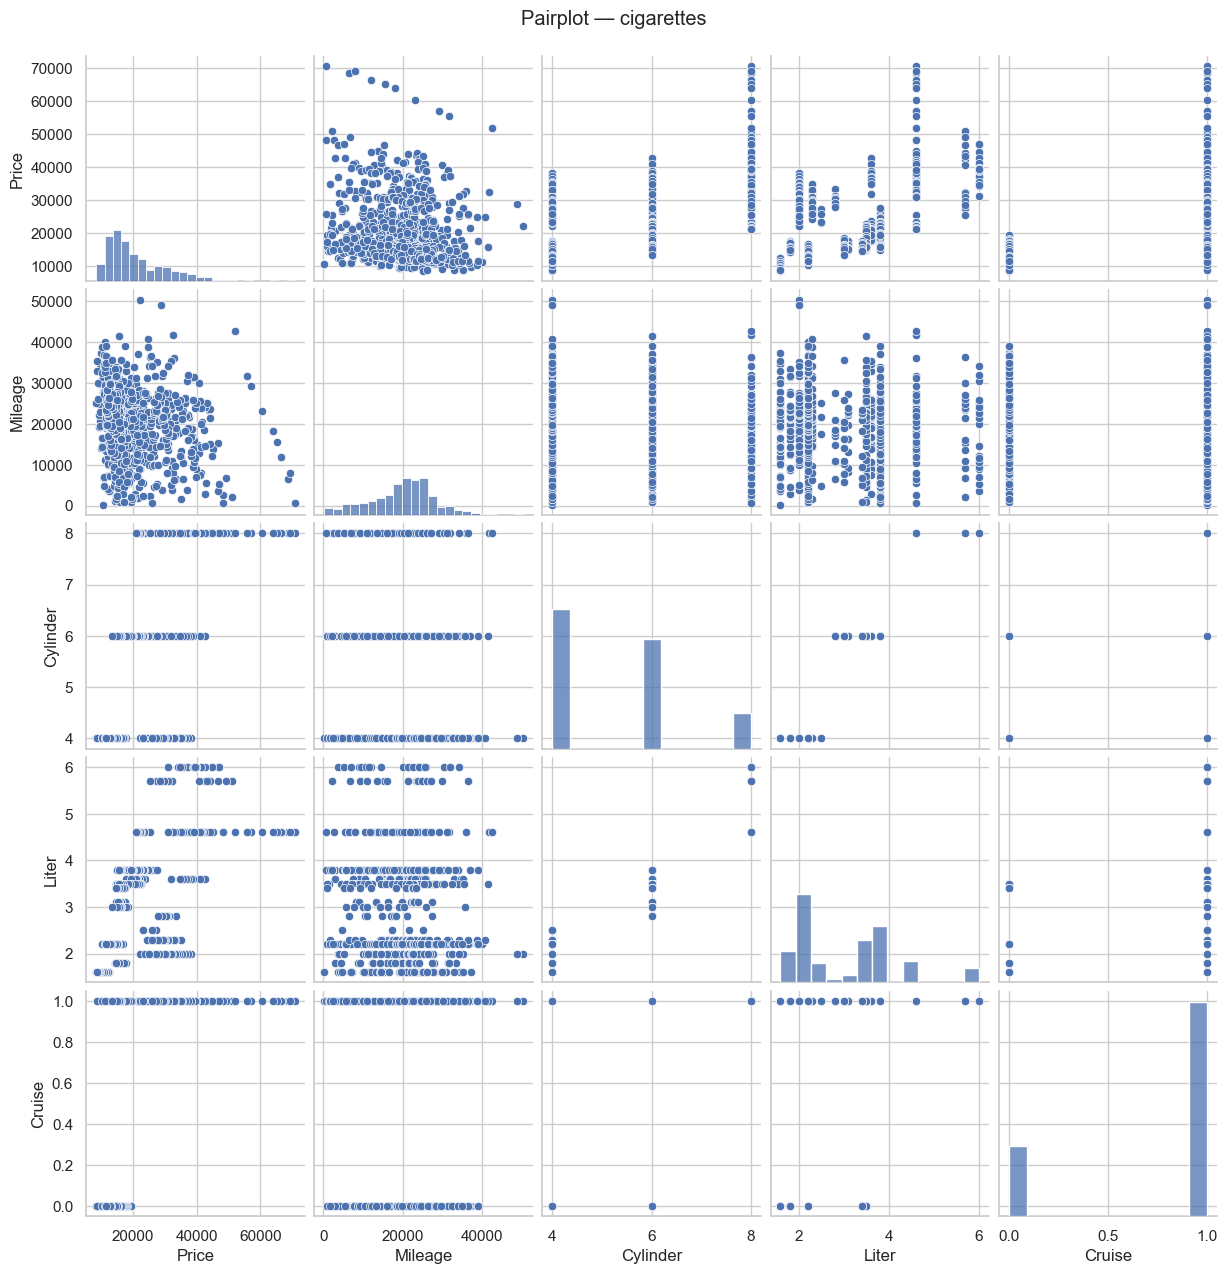

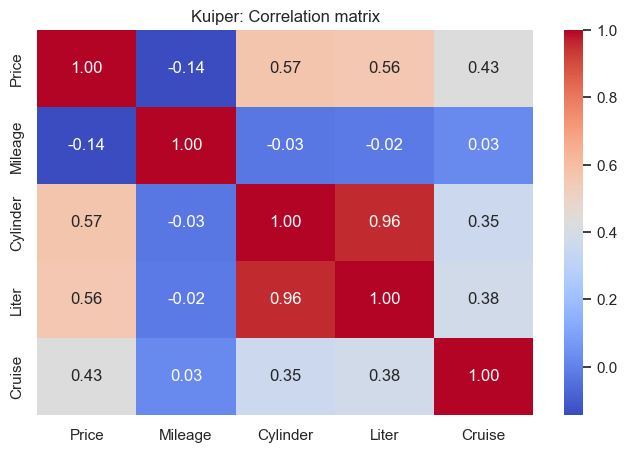

In [3]:
numDataKuiper = kuiperDataFrame[['Price','Mileage','Cylinder','Liter','Cruise']].dropna()
corrMatrixKuiper = numDataKuiper.corr()
print('Correlation matrix:')
display(corrMatrixKuiper)

sns.pairplot(numDataKuiper)
plt.suptitle('Pairplot — cigarettes', y=1.02)
plt.show()

plt.figure()
sns.heatmap(corrMatrixKuiper, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Kuiper: Correlation matrix')
plt.show()


### b) Построение базовой модели линейной регрессии
Будем моделировать `Price` как функцию `Mileage + Cylinder + Liter + Cruise` (без категориального представления марки/модели).

In [4]:
kuiperDataFrameClean = numDataKuiper.dropna().copy()
yKuiper = kuiperDataFrameClean['Price']
XKuiper = kuiperDataFrameClean[['Mileage','Cylinder','Liter','Cruise']]
XKuiperWithConst = sm.add_constant(XKuiper)

baseModelKuiper = sm.OLS(yKuiper, XKuiperWithConst).fit()
print('--- Base model summary ---')
print(baseModelKuiper.summary())


--- Base model summary ---
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     134.6
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           6.79e-88
Time:                        22:48:52   Log-Likelihood:                -8329.0
No. Observations:                 804   AIC:                         1.667e+04
Df Residuals:                     799   BIC:                         1.669e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2799.8569   1

### c) Вывод результатов базовой модели
Стандартный `summary()` уже содержит коэффициенты, стандартные ошибки, t-statistics, p-values, R-squared и F-statistic. Ниже — явный вывод ключевых величин.

In [5]:
coefficientsKuiper = baseModelKuiper.params
stdErrKuiper = baseModelKuiper.bse
tValuesKuiper = baseModelKuiper.tvalues
pValuesKuiper = baseModelKuiper.pvalues
fStatisticKuiper = baseModelKuiper.fvalue
fPvalueKuiper = baseModelKuiper.f_pvalue

print('\nCoefficients:\n', coefficientsKuiper, sep='')
print('\nStd. errors:\n', stdErrKuiper, sep='')
print('\nT-statistics:\n', tValuesKuiper, sep='')
print('\nP-values:\n', pValuesKuiper, sep='')
print('\nF-statistic = ', fStatisticKuiper, ', F p-value = ', fPvalueKuiper, sep='')



Coefficients:
const       2799.856853
Mileage       -0.164389
Cylinder    3007.802676
Liter        455.731055
Cruise      6076.048759
dtype: float64

Std. errors:
const       1543.264796
Mileage        0.033029
Cylinder     679.271164
Liter        860.596046
Cruise       676.570332
dtype: float64

T-statistics:
const       1.814243
Mileage    -4.977138
Cylinder    4.427985
Liter       0.529553
Cruise      8.980661
dtype: float64

P-values:
const       7.001531e-02
Mileage     7.906780e-07
Cylinder    1.083501e-05
Liter       5.965691e-01
Cruise      1.902591e-18
dtype: float64

F-statistic = 134.60677579025116, F p-value = 6.785641423070849e-88


### d) Уравнение линейной регрессии
Запишем уравнение в явном виде (с коэффициентами из модели).

In [6]:
interceptKuiper = coefficientsKuiper['const']
termsKuiper = []
for name in ['Mileage','Cylinder','Liter','Cruise']:
    coef = coefficientsKuiper[name]
    termsKuiper.append(f"({coef:.4f})*{name}")
equationKuiper = f"Price = {interceptKuiper:.4f} + " + ' + '.join(termsKuiper)
print('Regression equation:')
print(equationKuiper)


Regression equation:
Price = 2799.8569 + (-0.1644)*Mileage + (3007.8027)*Cylinder + (455.7311)*Liter + (6076.0488)*Cruise


### e) T-test значимости коэффициентов
Статистики t и p-values для каждого коэффициента.

In [7]:
# Тест всех коэффициентов (H0: каждый коэффициент = 0)
identityMatrix = np.eye(len(baseModelKuiper.params))
ttestAll = baseModelKuiper.t_test(identityMatrix)
print(ttestAll.summary())

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0          2799.8569   1543.265      1.814      0.070    -229.475    5829.189
c1            -0.1644      0.033     -4.977      0.000      -0.229      -0.100
c2          3007.8027    679.271      4.428      0.000    1674.436    4341.169
c3           455.7311    860.596      0.530      0.597   -1233.565    2145.027
c4          6076.0488    676.570      8.981      0.000    4747.984    7404.114


### f) F-test значимости уравнения регрессии
F-statistic и его p-value.

In [8]:
fStat = baseModelKuiper.fvalue
fPvalue = baseModelKuiper.f_pvalue
dfModel = int(baseModelKuiper.df_model) 
dfResid = int(baseModelKuiper.df_resid)
print(f'F-статистика = {fStat:.6f}')
print(f'p-значение для F = {fPvalue:.6f}')
print(f'df_model = {dfModel}, df_resid = {dfResid}')

F-статистика = 134.606776
p-значение для F = 0.000000
df_model = 4, df_resid = 799


### g) Scatterplots и линию регрессии
Построим scatter `Price` против каждого предиктора и линию предсказаний (прочие предикторы зафиксированы на средних).

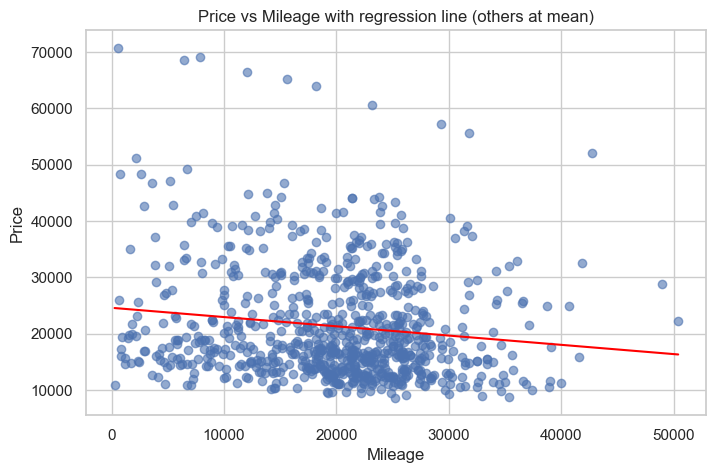

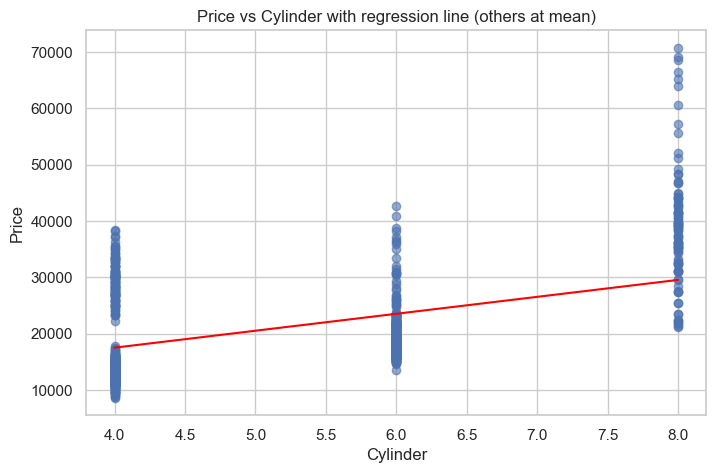

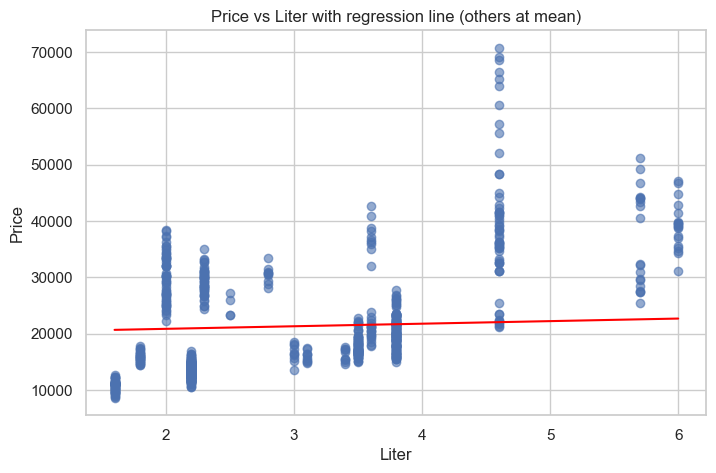

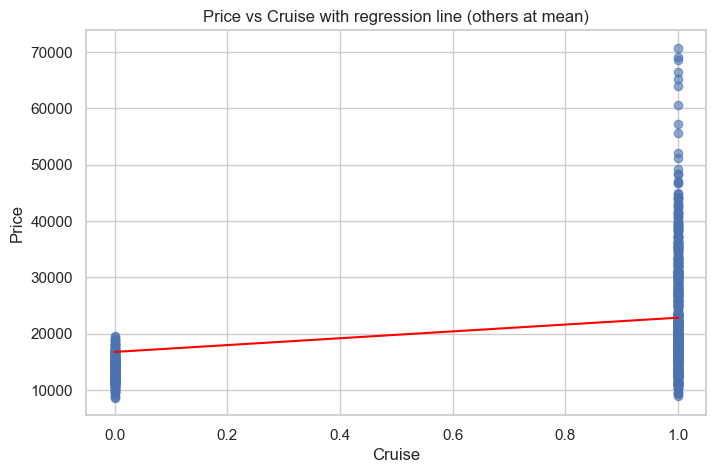

In [9]:
for xVar in ['Mileage', 'Cylinder', 'Liter', 'Cruise']:
    plt.figure()
    plt.scatter(kuiperDataFrameClean[xVar], yKuiper, alpha=0.6)

    xGrid = np.linspace(kuiperDataFrameClean[xVar].min(), kuiperDataFrameClean[xVar].max(), 100)
    meanValues = XKuiper.mean()

    predDf = pd.DataFrame({
        'Mileage': np.full_like(xGrid, meanValues['Mileage']),
        'Cylinder': np.full_like(xGrid, meanValues['Cylinder']),
        'Liter': np.full_like(xGrid, meanValues['Liter']),
        'Cruise': np.full_like(xGrid, meanValues['Cruise'])
    })
    predDf[xVar] = xGrid

    predDf = sm.add_constant(predDf, has_constant='add')
    yPredLine = baseModelKuiper.predict(predDf[baseModelKuiper.params.index])

    plt.plot(xGrid, yPredLine, color='red')
    plt.xlabel(xVar)
    plt.ylabel('Price')
    plt.title(f'Price vs {xVar} with regression line (others at mean)')
    plt.show()

### h) Доверительные интервалы для коэффициентов регрессии
Используем `conf_int()` из результатов модели.

In [10]:
ciKuiper = baseModelKuiper.conf_int(alpha=0.05)
ciKuiper.columns = ['CI_lower','CI_upper']
print('95% confidence intervals for coefficients:')
display(ciKuiper)

95% confidence intervals for coefficients:


,CI_lower,CI_upper
const,-229.475428,5829.189134
Mileage,-0.229222,-0.099555
Cylinder,1674.435862,4341.169490
Liter,-1233.565163,2145.027273
Cruise,4747.983509,7404.114008


### i) Важные наблюдения — влияние (influential observations)
Посчитаем Cook's distance и leverage; выведем великие наблюдения.

In [11]:
influenceKuiper = OLSInfluence(baseModelKuiper)
cooksD = influenceKuiper.cooks_distance[0]
leverage = influenceKuiper.hat_matrix_diag
standardizedResiduals = influenceKuiper.resid_studentized_internal

influenceSummaryDf = kuiperDataFrameClean.copy()
influenceSummaryDf['cooksD'] = cooksD
influenceSummaryDf['leverage'] = leverage
influenceSummaryDf['stdResid'] = standardizedResiduals

topCooks = influenceSummaryDf.sort_values('cooksD', ascending=False).head(10)
print('Top observations by Cook''s distance:')
display(topCooks[['Price','Mileage','Cylinder','Liter','Cruise','cooksD','leverage','stdResid']])


Top observations by Cooks distance:


,Price,Mileage,Cylinder,Liter,Cruise,cooksD,leverage,stdResid
150,70755.466717,583.0,8.0,4.6,1.0,0.070927,0.015712,4.713360
151,68566.187189,6420.0,8.0,4.6,1.0,0.051685,0.012362,4.543803
152,69133.731722,7892.0,8.0,4.6,1.0,0.051242,0.011717,4.648636
159,52001.994379,42691.0,8.0,4.6,1.0,0.040723,0.019944,3.163190
153,66374.307040,12021.0,8.0,4.6,1.0,0.039942,0.010339,4.372332
154,65281.481237,15600.0,8.0,4.6,1.0,0.036136,0.009657,4.304641
155,63913.117248,18200.0,8.0,4.6,1.0,0.033385,0.009460,4.180779
156,60567.549093,23193.0,8.0,4.6,1.0,0.029303,0.009787,3.850212
158,55639.087654,31805.0,8.0,4.6,1.0,0.029234,0.012530,3.394034
157,57154.443437,29260.0,8.0,4.6,1.0,0.028922,0.011432,3.536196


### j) Stepwise selection по AIC (forward-backward)
Реализуем простую функцию stepwise_selection, которая выбирает переменные по минимальному AIC.

In [12]:
def stepwiseSelection(X, y, initialList=[], thresholdIn=0.01, thresholdOut=0.05, verbose=True):
    included = list(initialList)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        bestAic = None
        bestToAdd = None

        for newCol in excluded:
            tryCols = included + [newCol]
            model = sm.OLS(y, sm.add_constant(X[tryCols])).fit()
            aic = model.aic
            if bestAic is None or aic < bestAic:
                bestAic = aic
                bestToAdd = newCol

        if bestToAdd is not None:
            currentModel = sm.OLS(y, sm.add_constant(X[included]) ).fit() if included else None
            currentAic = currentModel.aic if currentModel is not None else np.inf
            if bestAic + 1e-8 < currentAic:
                included.append(bestToAdd)
                changed=True
                if verbose:
                    print('Add  {:30} with AIC {:.6f}'.format(bestToAdd, bestAic))

        if included:
            bestAic = None
            worstToRemove = None
            for col in included:
                tryCols = list(included)
                tryCols.remove(col)
                model = sm.OLS(y, sm.add_constant(X[tryCols]) ).fit()
                aic = model.aic
                if bestAic is None or aic < bestAic:
                    bestAic = aic
                    worstToRemove = col
            currentModel = sm.OLS(y, sm.add_constant(X[included]) ).fit()
            currentAic = currentModel.aic
            if bestAic + 1e-8 < currentAic:
                included.remove(worstToRemove)
                changed=True
                if verbose:
                    print('Remove {:30} to improve AIC to {:.6f}'.format(worstToRemove, bestAic))

        if not changed:
            break
    
    return included

candidateX = XKuiper.copy()
selectedVarsKuiper = stepwiseSelection(candidateX, yKuiper, verbose=True)
print('\nSelected variables by stepwise AIC:', selectedVarsKuiper)


Add  Cylinder                       with AIC 16761.608386
Add  Cruise                         with AIC 16688.778464
Add  Mileage                        with AIC 16666.364701

Selected variables by stepwise AIC: ['Cylinder', 'Cruise', 'Mileage']


### k) Если модель улучшилась — повторим пункты c–i для новой модели
Если `selectedVarsKuiper` отличается от исходного набора, подгоним новую модель и повторим диагностику.

In [13]:
if set(selectedVarsKuiper) != set(XKuiper.columns):
    print('Fitting improved model with vars:', selectedVarsKuiper)
    XKuiperSelected = sm.add_constant(XKuiper[selectedVarsKuiper])
    improvedModelKuiper = sm.OLS(yKuiper, XKuiperSelected).fit()
    print(improvedModelKuiper.summary())
else:
    print('Stepwise did not change the model (selected == full).')


Fitting improved model with vars: ['Cylinder', 'Cruise', 'Mileage']
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     179.5
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           5.35e-89
Time:                        22:48:52   Log-Likelihood:                -8329.2
No. Observations:                 804   AIC:                         1.667e+04
Df Residuals:                     800   BIC:                         1.669e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

### l) Построить diagnostic-графики и дать интерпретации
Построим: scatterplot (все пары), Residuals vs Fitted, Normal Q-Q, Residuals vs Leverage (с указанием Cook's distance).

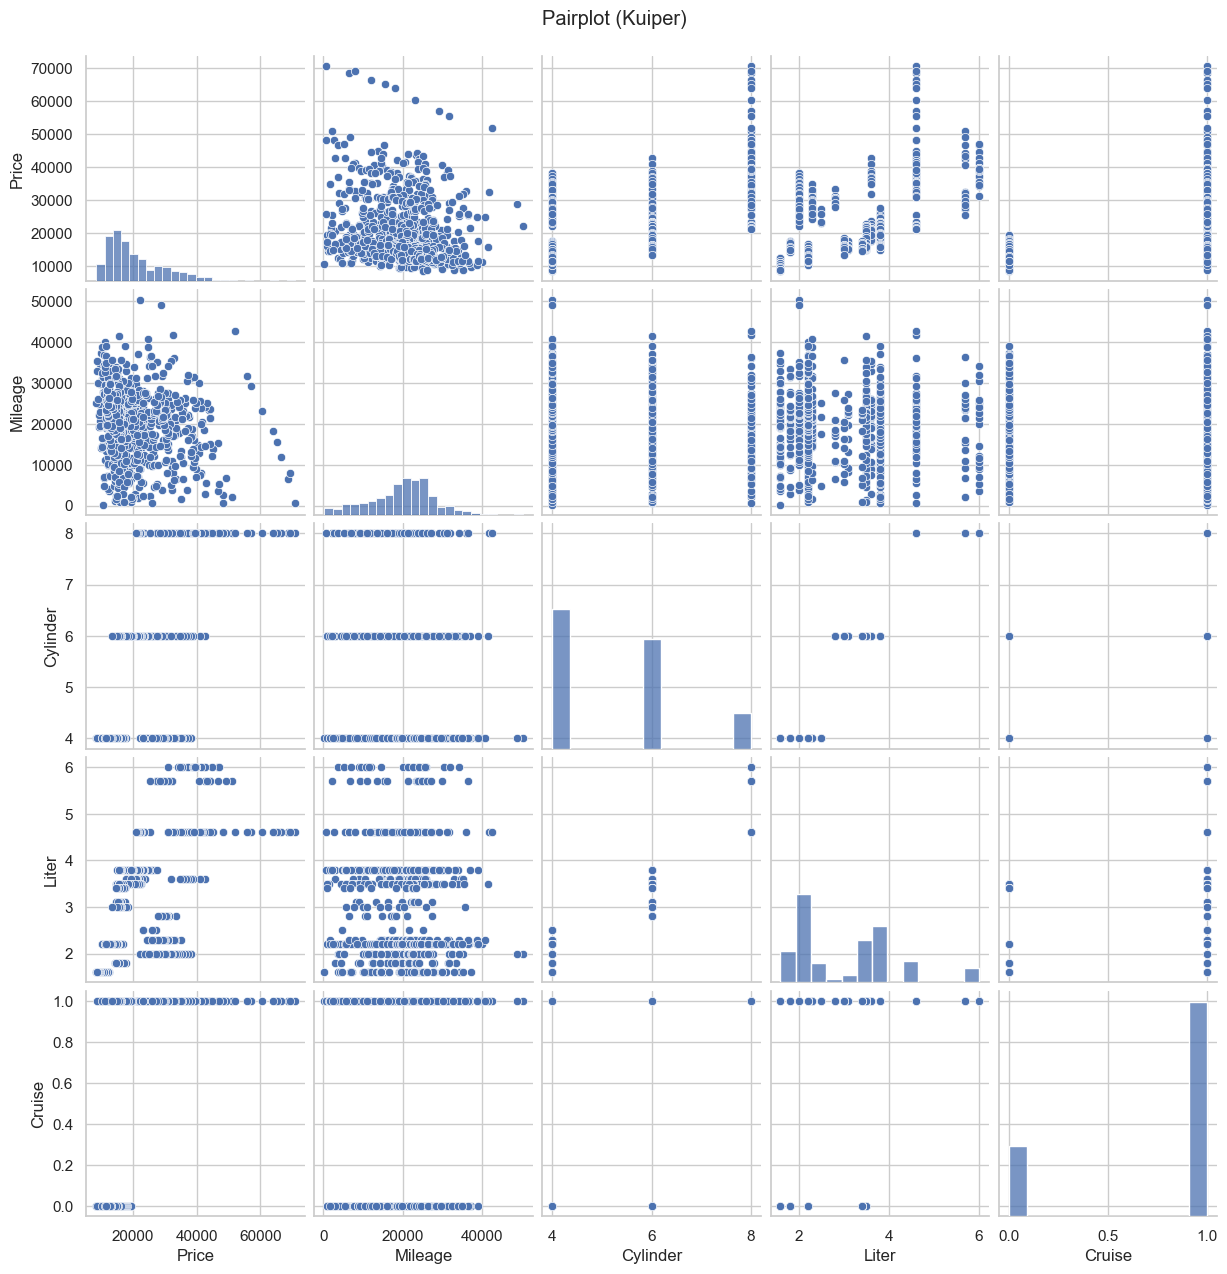

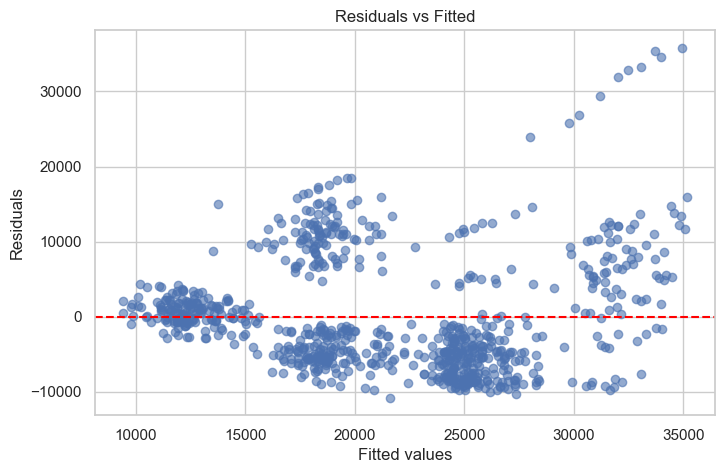

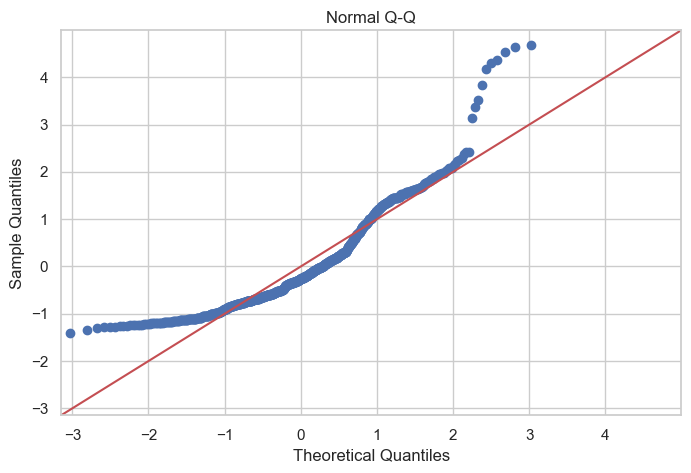

<Figure size 800x600 with 0 Axes>

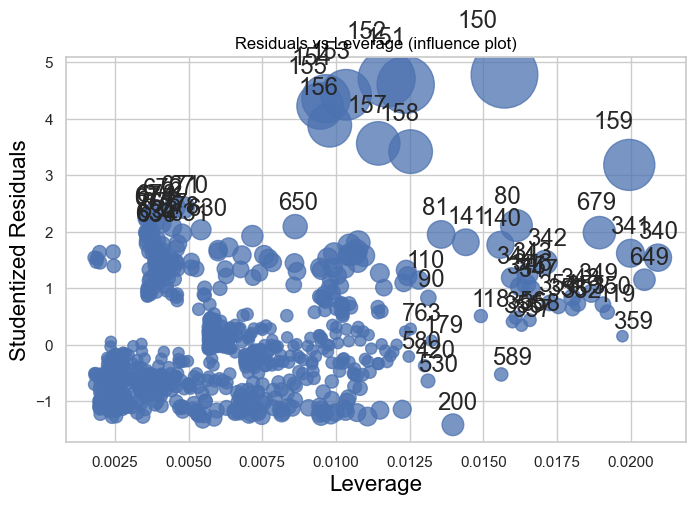

In [14]:
sns.pairplot(kuiperDataFrameClean[['Price','Mileage','Cylinder','Liter','Cruise']])
plt.suptitle('Pairplot (Kuiper)', y=1.02)
plt.show()

# Residuals vs Fitted
fittedVals = baseModelKuiper.fittedvalues
residuals = baseModelKuiper.resid
plt.figure()
plt.scatter(fittedVals, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

# Normal Q-Q
sm.qqplot(residuals, line='45', fit=True)
plt.title('Normal Q-Q')
plt.show()

# Residuals vs Leverage (with Cook's distance contour)
fig = plt.figure(figsize=(8,6))
sm.graphics.influence_plot(baseModelKuiper, criterion='cooks')
plt.title('Residuals vs Leverage (influence plot)')
plt.show()


### m) Проверка на выбросы (outliers)
- Посмотреть большие по абсолютному значению стандартизованные/студентализованные остатки (|t_resid| > 3).

In [15]:
influence = OLSInfluence(baseModelKuiper)
studentResid = influence.resid_studentized_external
outlierMask = np.abs(studentResid) > 3
print('Number of potential outliers (|studentized resid| > 3):', outlierMask.sum())
if outlierMask.sum()>0:
    display(kuiperDataFrameClean.loc[outlierMask, ['Price','Mileage','Cylinder','Liter','Cruise']].assign(studentResid=studentResid[outlierMask]))

Number of potential outliers (|studentized resid| > 3): 10


,Price,Mileage,Cylinder,Liter,Cruise,studentResid
150,70755.466717,583.0,8.0,4.6,1.0,4.777293
151,68566.187189,6420.0,8.0,4.6,1.0,4.600790
152,69133.731722,7892.0,8.0,4.6,1.0,4.709854
153,66374.307040,12021.0,8.0,4.6,1.0,4.422827
154,65281.481237,15600.0,8.0,4.6,1.0,4.352716
155,63913.117248,18200.0,8.0,4.6,1.0,4.224626
156,60567.549093,23193.0,8.0,4.6,1.0,3.884001
157,57154.443437,29260.0,8.0,4.6,1.0,3.561966
158,55639.087654,31805.0,8.0,4.6,1.0,3.416628
159,52001.994379,42691.0,8.0,4.6,1.0,3.181191


### n) Тест на гетероскедастичность
- Breusch–Pagan тест.

In [16]:
bpTest = het_breuschpagan(residuals, baseModelKuiper.model.exog)
bpStat, bpPvalue = bpTest[0], bpTest[1]
print('\nBreusch-Pagan: statistic =', bpStat, ', p-value =', bpPvalue)


Breusch-Pagan: statistic = 95.36525532087381 , p-value = 9.529539966312405e-20


### o) Тест на автокорреляцию остатков
- Durbin–Watson.

In [17]:
dwStat = durbin_watson(residuals)
print('\nDurbin-Watson statistic =', dwStat)


Durbin-Watson statistic = 0.2169462123989751


### p) Нормальность остатков
- Shapiro и Jarque–Bera.

In [18]:
jbStat, jbPvalue, skewResid, kurtResid = sm.stats.stattools.jarque_bera(residuals)
shStatRes, shPRes = sps.shapiro(residuals)
print('\nJarque-Bera: stat =', jbStat, ', p-value =', jbPvalue)
print('Shapiro-Wilk on residuals: stat =', shStatRes, ', p-value =', shPRes)


Jarque-Bera: stat = 395.298228098107 , p-value = 1.4523805203622995e-86
Shapiro-Wilk on residuals: stat = 0.893742013141704 , p-value = 4.090386740405164e-23


### q) Мультиколлинеарность
- VIF для каждой регрессора.

In [19]:
vifData = pd.DataFrame()
vifData['feature'] = XKuiper.columns
vifData['VIF'] = [variance_inflation_factor(XKuiper.values, i) for i in range(XKuiper.shape[1])]
print('\nVIF:')
display(vifData)


VIF:


,feature,VIF
0,Mileage,5.445246
1,Cylinder,87.002965
2,Liter,71.356012
3,Cruise,4.631138


### r) Попытка Box–Cox трансформации отклика `Price`
### s) Если Box–Cox дал новую модель — проанализировать её.  

In [20]:
yBox, lambdaBox = sps.boxcox(yKuiper)
print('Box-Cox lambda =', lambdaBox)

modelBoxKuiper = sm.OLS(yBox, XKuiperWithConst).fit()
print(modelBoxKuiper.summary())
print('\nBase AIC =', baseModelKuiper.aic, ', Box-Cox model AIC =', modelBoxKuiper.aic)

Box-Cox lambda = -0.5795770193633994
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     183.5
Date:                Wed, 29 Oct 2025   Prob (F-statistic):          1.66e-111
Time:                        22:48:54   Log-Likelihood:                 4466.2
No. Observations:                 804   AIC:                            -8922.
Df Residuals:                     799   BIC:                            -8899.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

# Регрессионный анализ: cigarettes.dat.txt

Анализ включает полный набор шагов, аналогичный ноутбуку для `Kuiper.xls`:
- загрузка и предобработка данных;
- корреляционный анализ и EDA (гистограммы/парные графики);
- построение базовой линейной модели: `carbonMonoxide ~ tar + nicotine + weight`;
- вывод результата (коэффициенты, t-test для каждого коэффициента, F-test для модели);
- уравнение регрессии;
- доверительные интервалы для коэффициентов;
- влияние (Cook's distance, leverage) и поиск influential observations;
- пошаговый подбор модели по AIC (stepwise);
- diagnostic-графики: Residuals vs Fitted, Normal Q-Q, Residuals vs Leverage;
- тесты: Breusch–Pagan (гетероскедастичность), Durbin–Watson (автокорреляция), Jarque–Bera и Shapiro (нормальность остатков), VIF (мультиколлинеарность);
- Box–Cox трансформация отклика и повторный анализ.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 11
sns.set(style='whitegrid')


## Загрузка и предобработка `cigarettes.dat.txt`

In [22]:
rawLines = []
with open('../datasets/cigarettes.dat.txt', 'r', encoding='utf-8') as fileHandle:
    for line in fileHandle:
        lineStr = line.strip()
        if lineStr:
            rawLines.append(lineStr)

rows = []
for line in rawLines:
    tokens = line.split()
    if len(tokens) < 5:
        continue
    numericTokens = tokens[-4:]
    brandTokens = tokens[:-4]
    brand = ' '.join(brandTokens)
    try:
        carbonMonoxideVal = float(numericTokens[0].replace(',', '.'))
        tarVal = float(numericTokens[1].replace(',', '.'))
        nicotineVal = float(numericTokens[2].replace(',', '.'))
        weightVal = float(numericTokens[3].replace(',', '.'))
    except Exception as parseErr:
        continue
    rows.append((brand, carbonMonoxideVal, tarVal, nicotineVal, weightVal))

cigarettesDataFrame = pd.DataFrame(rows, columns=['brand','carbonMonoxide','tar','nicotine','weight'])
print('Loaded rows =', len(cigarettesDataFrame))
display(cigarettesDataFrame.head(10))
print('\nSummary:')
display(cigarettesDataFrame.describe())


Loaded rows = 25


,brand,carbonMonoxide,tar,nicotine,weight
0,Alpine,14.1,0.86,0.9853,13.6
1,Benson&Hedges,16.0,1.06,1.0938,16.6
2,BullDurham,29.8,2.03,1.1650,23.5
3,CamelLights,8.0,0.67,0.9280,10.2
4,Carlton,4.1,0.40,0.9462,5.4
5,Chesterfield,15.0,1.04,0.8885,15.0
6,GoldenLights,8.8,0.76,1.0267,9.0
7,Kent,12.4,0.95,0.9225,12.3
8,Kool,16.6,1.12,0.9372,16.3
9,L&M,14.9,1.02,0.8858,15.4



Summary:


,carbonMonoxide,tar,nicotine,weight
count,25.00000,25.000000,25.000000,25.000000
mean,12.21600,0.876400,0.970284,12.528000
std,5.66581,0.354058,0.087721,4.739684
min,1.00000,0.130000,0.785100,1.500000
25%,8.60000,0.690000,0.922500,10.000000
50%,12.80000,0.900000,0.957300,13.000000
75%,15.10000,1.020000,1.007000,15.400000
max,29.80000,2.030000,1.165000,23.500000


### a) Корреляционный анализ

Correlation matrix:


,carbonMonoxide,tar,nicotine,weight
carbonMonoxide,1.000000,0.976608,0.490765,0.957485
tar,0.976608,1.000000,0.500183,0.925947
nicotine,0.490765,0.500183,1.000000,0.463959
weight,0.957485,0.925947,0.463959,1.000000


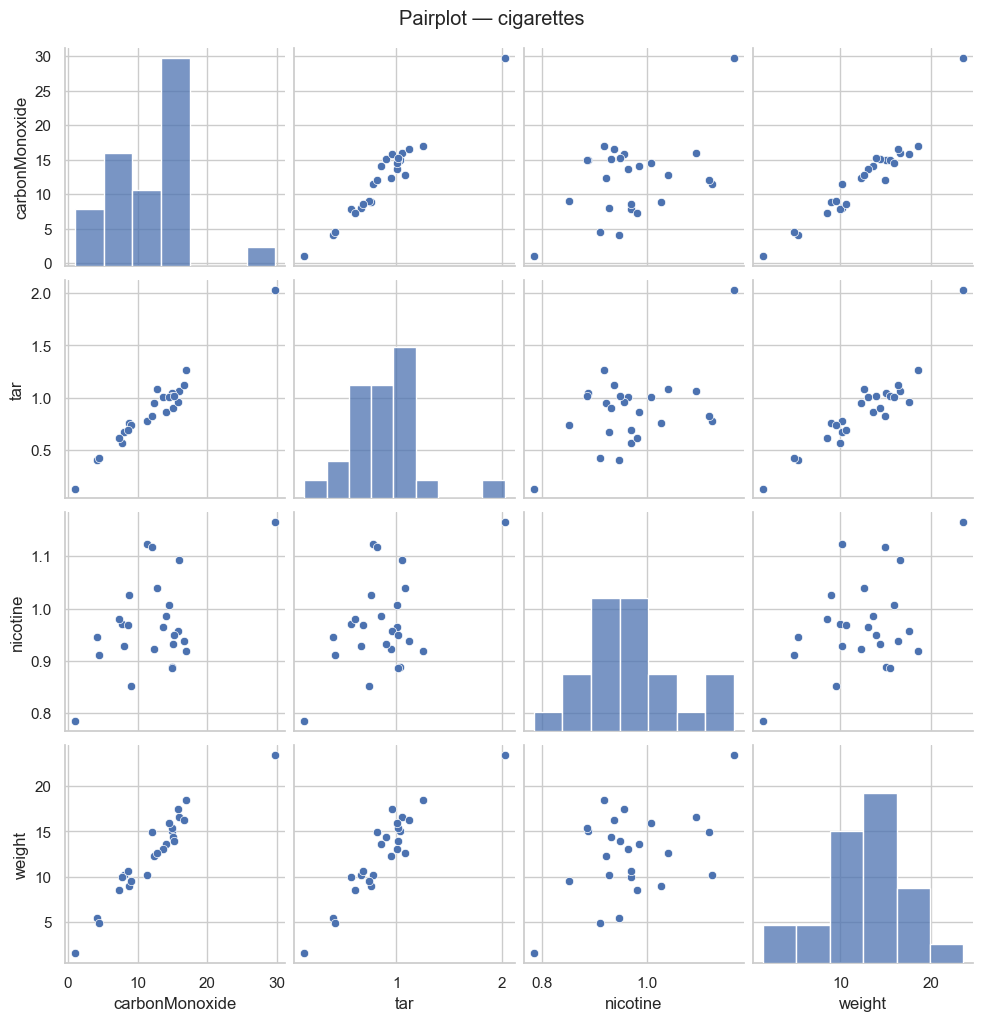

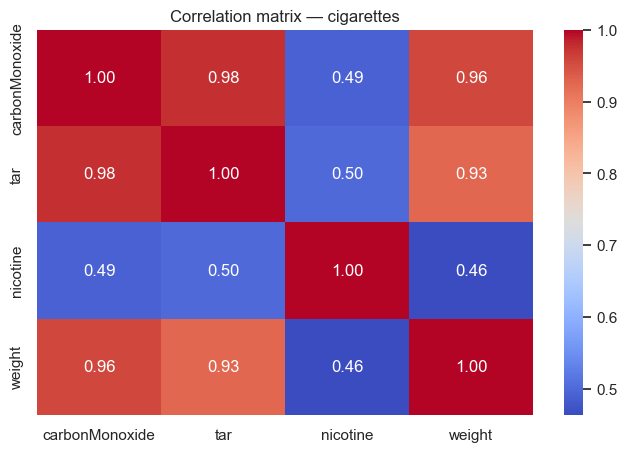

In [23]:
numericCig = cigarettesDataFrame[['carbonMonoxide','tar','nicotine','weight']].dropna()
print('Correlation matrix:')
display(numericCig.corr())

sns.pairplot(numericCig)
plt.suptitle('Pairplot — cigarettes', y=1.02)
plt.show()

plt.figure()
sns.heatmap(numericCig.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix — cigarettes')
plt.show()


### b) Базовая линейная модель
Задаём модель: `carbonMonoxide ~ tar + nicotine + weight`

In [24]:
cigClean = cigarettesDataFrame.dropna(subset=['carbonMonoxide','tar','nicotine','weight']).copy()
yCig = cigClean['carbonMonoxide']
XCig = cigClean[['tar','nicotine','weight']]
XCigWithConst = sm.add_constant(XCig)
cigModel = sm.OLS(yCig, XCigWithConst).fit()
print('--- Base OLS model summary ---')
print(cigModel.summary())


--- Base OLS model summary ---
                            OLS Regression Results                            
Dep. Variable:         carbonMonoxide   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     258.3
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           9.95e-17
Time:                        22:48:55   Log-Likelihood:                -32.889
No. Observations:                  25   AIC:                             73.78
Df Residuals:                      21   BIC:                             78.65
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3696

### c) Вывод результатов базовой модели
Стандартный `summary()` уже содержит коэффициенты, стандартные ошибки, t-statistics, p-values, R-squared и F-statistic. Ниже — явный вывод ключевых величин.

In [25]:
coefficientsCig = cigModel.params
stdErrCig = cigModel.bse
tValuesCig = cigModel.tvalues
pValuesCig = cigModel.pvalues
fStatisticCig = cigModel.fvalue
fPvalueCig = cigModel.f_pvalue

print('\nCoefficients:\n', coefficientsCig, sep='')
print('\nStd. errors:\n', stdErrCig, sep='')
print('\nT-statistics:\n', tValuesCig, sep='')
print('\nP-values:\n', pValuesCig, sep='')
print('\nF-statistic = ', fStatisticCig, ', F p-value = ', fPvalueCig, sep='')



Coefficients:
const       -2.369585
tar         10.080304
nicotine     0.170439
weight       0.445868
dtype: float64

Std. errors:
const       2.347278
tar         1.536689
nicotine    2.644137
weight      0.112208
dtype: float64

T-statistics:
const      -1.009503
tar         6.559757
nicotine    0.064459
weight      3.973566
dtype: float64

P-values:
const       0.324224
tar         0.000002
nicotine    0.949214
weight      0.000692
dtype: float64

F-statistic = 258.25895913167096, F p-value = 9.949064852223815e-17


### d) Уравнение линейной регрессии
Запишем уравнение в явном виде (с коэффициентами из модели).

In [26]:
interceptCig = coefficientsCig['const']
termsCig = []
for name in ['tar','nicotine','weight']:
    termsCig.append(f"({coefficientsCig[name]:.4f})*{name}")
equationCig = f"carbonMonoxide = {interceptCig:.4f} + " + ' + '.join(termsCig)
print('Regression equation:')
print(equationCig)


Regression equation:
carbonMonoxide = -2.3696 + (10.0803)*tar + (0.1704)*nicotine + (0.4459)*weight


### e) T-test значимости коэффициентов
Статистики t и p-values для каждого коэффициента.

In [27]:
# Тест всех коэффициентов (H0: каждый коэффициент = 0)
identityMatrix = np.eye(len(cigModel.params))
tTestAll = cigModel.t_test(identityMatrix)
print(tTestAll.summary())

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -2.3696      2.347     -1.010      0.324      -7.251       2.512
c1            10.0803      1.537      6.560      0.000       6.885      13.276
c2             0.1704      2.644      0.064      0.949      -5.328       5.669
c3             0.4459      0.112      3.974      0.001       0.213       0.679


### f) F-test значимости уравнения регрессии
F-statistic и его p-value.

In [28]:
fStat = cigModel.fvalue
fP = cigModel.f_pvalue
print(f'F-statistic = {fStat:.6f}, p-value = {fP:.6f}')


F-statistic = 258.258959, p-value = 0.000000


### g) Scatterplots и линию регрессии
Построим scatter `carbonMonoxide` против каждого предиктора и линию предсказаний (прочие предикторы зафиксированы на средних).

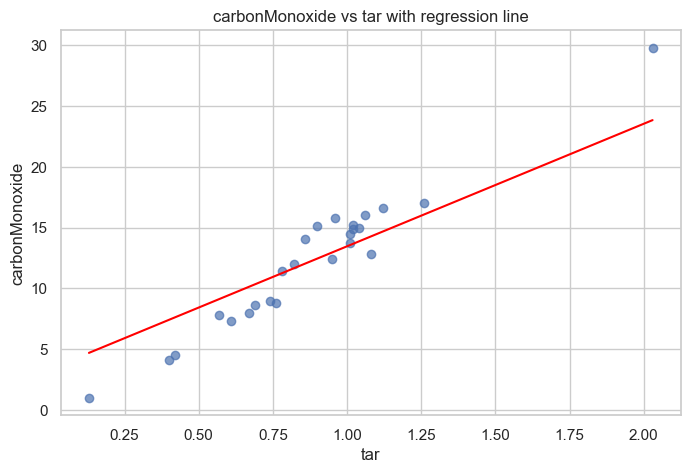

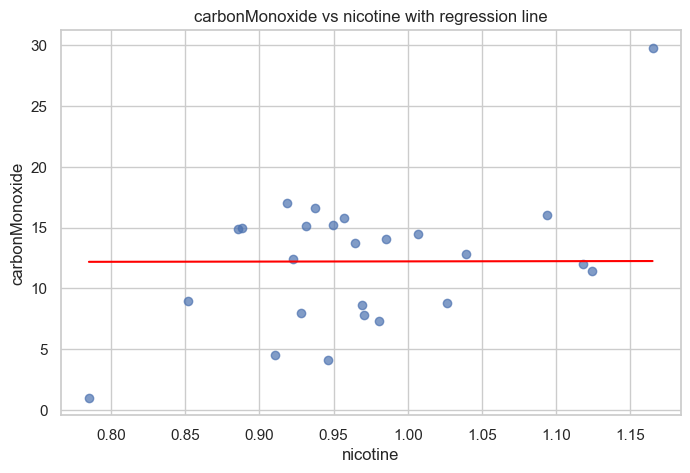

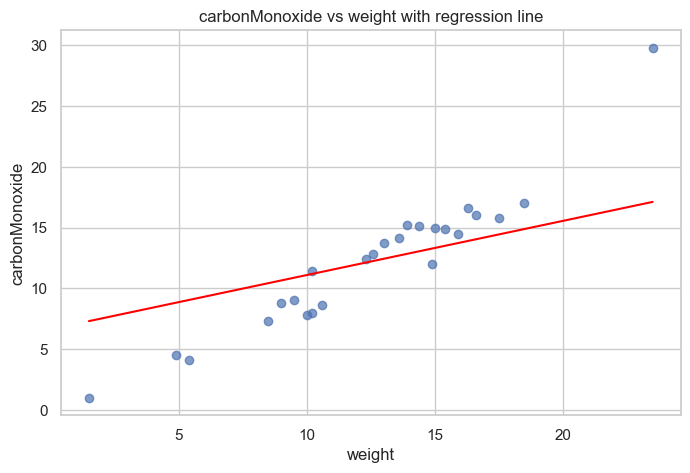

In [29]:
for xVar in ['tar', 'nicotine', 'weight']:
    plt.figure()
    plt.scatter(cigClean[xVar], yCig, alpha=0.7)

    xGrid = np.linspace(cigClean[xVar].min(), cigClean[xVar].max(), 100)
    meanValues = XCig.mean()

    predDf = pd.DataFrame({
        'tar': np.full_like(xGrid, meanValues['tar']),
        'nicotine': np.full_like(xGrid, meanValues['nicotine']),
        'weight': np.full_like(xGrid, meanValues['weight'])
    })
    predDf[xVar] = xGrid

    predDf = sm.add_constant(predDf, has_constant='add')
    yPred = cigModel.predict(predDf[cigModel.params.index])

    plt.plot(xGrid, yPred, color='red')
    plt.xlabel(xVar)
    plt.ylabel('carbonMonoxide')
    plt.title(f'carbonMonoxide vs {xVar} with regression line')
    plt.show()


### h) Доверительные интервалы для коэффициентов регрессии
Используем `conf_int()` из результатов модели.

In [30]:
ciCig = cigModel.conf_int(alpha=0.05)
ciCig.columns = ['CI_lower','CI_upper']
print('95% confidence intervals for coefficients:')
display(ciCig)


95% confidence intervals for coefficients:


,CI_lower,CI_upper
const,-7.251016,2.511847
tar,6.884585,13.276023
nicotine,-5.328344,5.669223
weight,0.212517,0.679218


### i) Важные наблюдения — влияние (influential observations)
Посчитаем Cook's distance и leverage; выведем великие наблюдения.

In [31]:
influenceCig = OLSInfluence(cigModel)
cooksDCig = influenceCig.cooks_distance[0]
leverageCig = influenceCig.hat_matrix_diag
studentResidCig = influenceCig.resid_studentized_external

influenceSummaryCig = cigClean.copy()
influenceSummaryCig['cooksD'] = cooksDCig
influenceSummaryCig['leverage'] = leverageCig
influenceSummaryCig['studentResid'] = studentResidCig

print('Top observations by Cook''s distance:')
display(influenceSummaryCig.sort_values('cooksD', ascending=False).head(10))


Top observations by Cooks distance:


,brand,carbonMonoxide,tar,nicotine,weight,cooksD,leverage,studentResid
2,BullDurham,29.8,2.03,1.1650,23.5,1.411701,0.645920,1.859498
15,Now,1.0,0.13,0.7851,1.5,0.296098,0.327984,1.616525
16,OldGold,17.0,1.26,0.9186,18.5,0.207589,0.179455,-2.100951
13,MultiFilter,11.4,0.78,1.1240,10.2,0.165225,0.258258,1.409757
17,PallMallLight,12.8,1.08,1.0395,12.6,0.118309,0.146085,-1.741891
24,WinstonLights,12.0,0.82,1.1184,14.9,0.105411,0.336718,-0.907521
11,Marlboro,15.1,0.90,0.9316,14.4,0.086932,0.085232,2.079070
0,Alpine,14.1,0.86,0.9853,13.6,0.045853,0.063306,1.722848
18,Raleigh,15.8,0.96,0.9573,17.5,0.031376,0.247846,0.607817
6,GoldenLights,8.8,0.76,1.0267,9.0,0.022024,0.137515,-0.735148


### j) Stepwise selection по AIC (forward-backward)
Реализуем простую функцию stepwise_selection, которая выбирает переменные по минимальному AIC.

In [32]:
def stepwiseSelection(X, y, initialList=[], verbose=True):
    included = list(initialList)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        bestAic = None
        bestToAdd = None
        for newCol in excluded:
            tryCols = included + [newCol]
            model = sm.OLS(y, sm.add_constant(X[tryCols])).fit()
            aic = model.aic
            if bestAic is None or aic < bestAic:
                bestAic = aic
                bestToAdd = newCol
        if bestToAdd is not None:
            currentModel = sm.OLS(y, sm.add_constant(X[included]) ).fit() if included else None
            currentAic = currentModel.aic if currentModel is not None else np.inf
            if bestAic + 1e-8 < currentAic:
                included.append(bestToAdd)
                changed=True
                if verbose:
                    print('Add {:20} with AIC {:.6f}'.format(bestToAdd, bestAic))
        if included:
            bestAic = None
            worstToRemove = None
            for col in included:
                tryCols = list(included)
                tryCols.remove(col)
                model = sm.OLS(y, sm.add_constant(X[tryCols]) ).fit()
                aic = model.aic
                if bestAic is None or aic < bestAic:
                    bestAic = aic
                    worstToRemove = col
            currentModel = sm.OLS(y, sm.add_constant(X[included]) ).fit()
            currentAic = currentModel.aic
            if bestAic + 1e-8 < currentAic:
                included.remove(worstToRemove)
                changed=True
                if verbose:
                    print('Remove {:20} to improve AIC to {:.6f}'.format(worstToRemove, bestAic))
        if not changed:
            break
    return included

selectedVarsCig = stepwiseSelection(XCig, yCig, verbose=True)
print('\nSelected variables by stepwise AIC:', selectedVarsCig)


Add tar                  with AIC 83.799780
Add weight               with AIC 71.783904

Selected variables by stepwise AIC: ['tar', 'weight']


### k) Если модель улучшилась — повторим пункты c–i для новой модели
Если `selectedVarsCig` отличается от исходного набора, подгоним новую модель и повторим диагностику.

In [33]:
if set(selectedVarsCig) != set(XCig.columns):
    print('Fitting improved model with vars:', selectedVarsCig)
    XCigSelected = sm.add_constant(XCig[selectedVarsCig])
    improvedCigModel = sm.OLS(yCig, XCigSelected).fit()
    print(improvedCigModel.summary())
else:
    print('Stepwise did not change the model (selected == full).')


Fitting improved model with vars: ['tar', 'weight']
                            OLS Regression Results                            
Dep. Variable:         carbonMonoxide   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     405.8
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           4.33e-18
Time:                        22:48:56   Log-Likelihood:                -32.892
No. Observations:                  25   AIC:                             71.78
Df Residuals:                      22   BIC:                             75.44
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


### l) Построить diagnostic-графики и дать интерпретации
Построим: scatterplot (все пары), Residuals vs Fitted, Normal Q-Q, Residuals vs Leverage (с указанием Cook's distance).

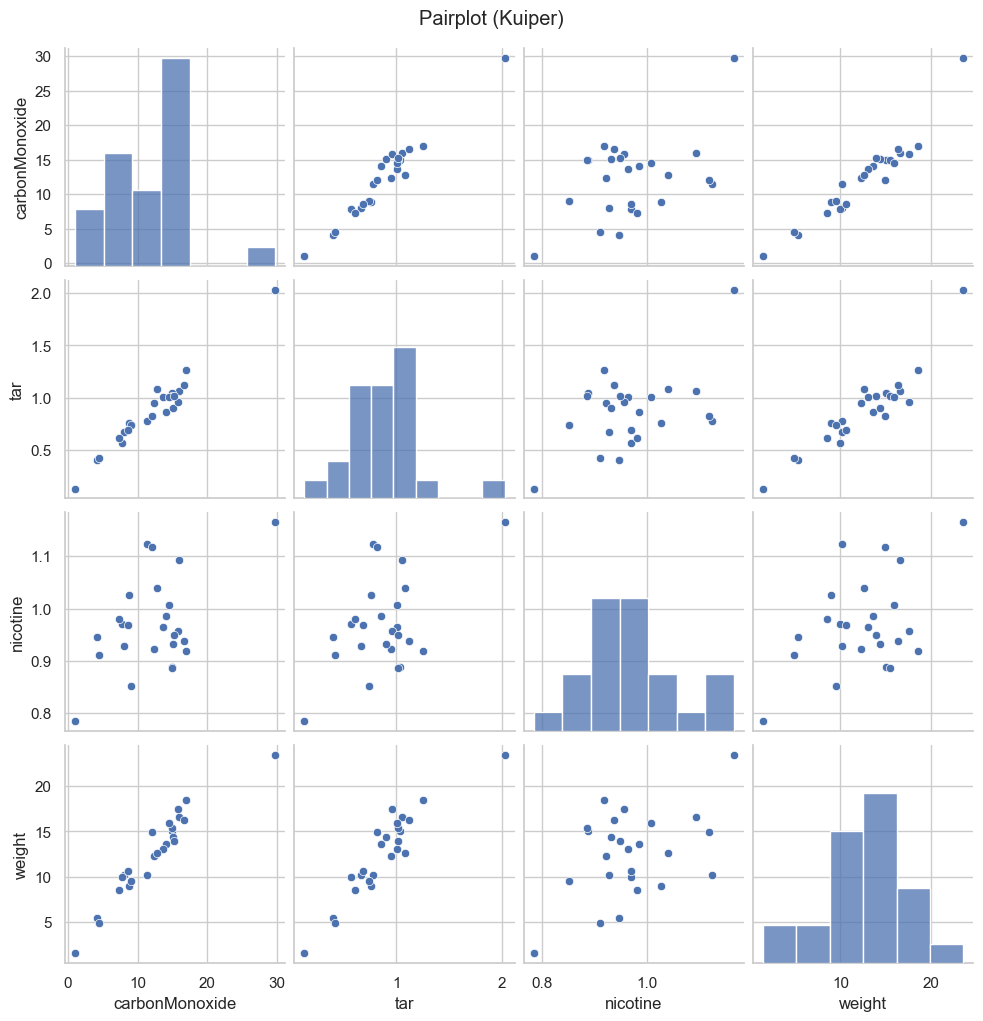

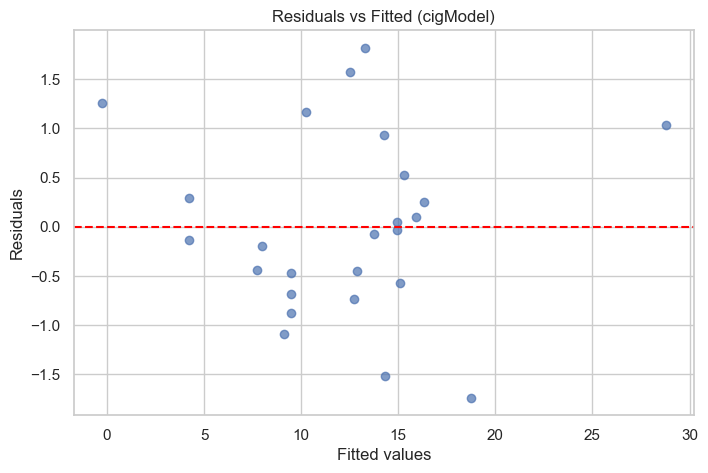

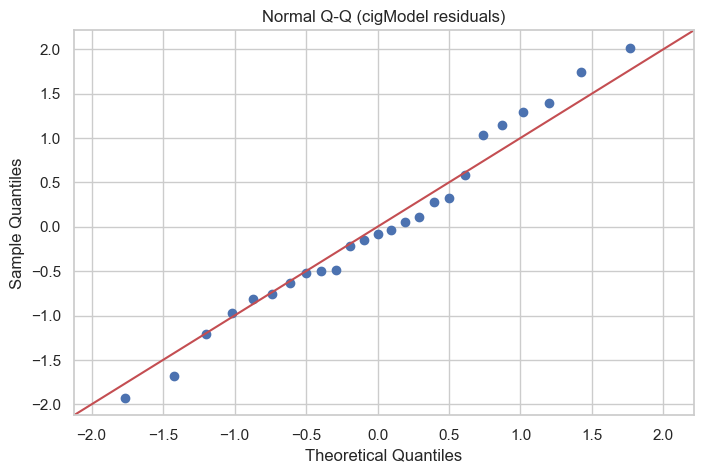

<Figure size 800x600 with 0 Axes>

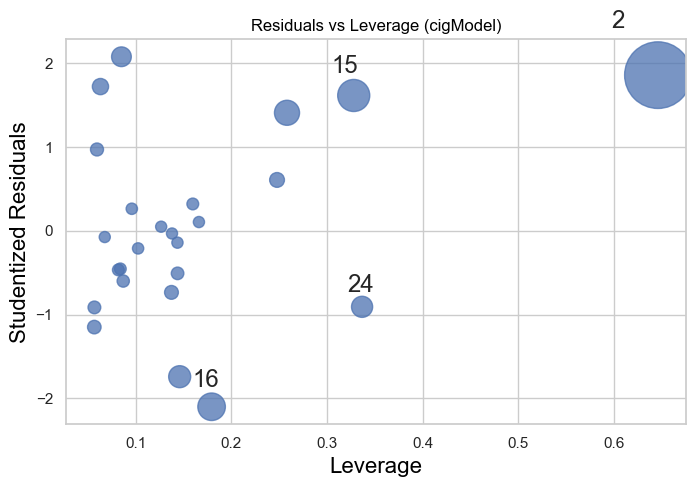

In [34]:
sns.pairplot(cigClean[['carbonMonoxide','tar','nicotine','weight']])
plt.suptitle('Pairplot (Kuiper)', y=1.02)
plt.show()

# Residuals vs Fitted
plt.figure()
plt.scatter(cigModel.fittedvalues, cigModel.resid, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted (cigModel)')
plt.show()

# Normal Q-Q
sm.qqplot(cigModel.resid, line='45', fit=True)
plt.title('Normal Q-Q (cigModel residuals)')
plt.show()

# Residuals vs Leverage (influence)
fig = plt.figure(figsize=(8,6))
sm.graphics.influence_plot(cigModel, criterion='cooks')
plt.title('Residuals vs Leverage (cigModel)')
plt.show()


### m) Проверка на выбросы (outliers)
- Посмотреть большие по абсолютному значению стандартизованные/студентализованные остатки (|t_resid| > 3).

In [35]:
influence = OLSInfluence(cigModel)
studentResid = influence.resid_studentized_external
outlierMask = np.abs(studentResid) > 3
print('Number of potential outliers (|studentized resid| > 3):', outlierMask.sum())
if outlierMask.sum()>0:
    display(cigClean.loc[outlierMask, ['brand','carbonMonoxide','tar','nicotine','weight']].assign(studentResid=studentResid[outlierMask]))

Number of potential outliers (|studentized resid| > 3): 0


### n) Тест на гетероскедастичность
- Breusch–Pagan тест.

In [36]:
bpTest = het_breuschpagan(cigModel.resid, cigModel.model.exog)
print('\nBreusch-Pagan: LM stat =', bpTest[0], ', p-value =', bpTest[1])


Breusch-Pagan: LM stat = 0.5788882004916951 , p-value = 0.9012479670908604


### o) Тест на автокорреляцию остатков
- Durbin–Watson.

In [37]:
dw = durbin_watson(cigModel.resid)
print('\nDurbin-Watson statistic =', dw)


Durbin-Watson statistic = 2.2143333336042272


### p) Нормальность остатков
- Shapiro и Jarque–Bera.

In [38]:
jbStat, jbP, skewResid, kurtResid = sm.stats.stattools.jarque_bera(cigModel.resid)
shStat, shP = sps.shapiro(cigModel.resid)
print('\nJarque-Bera: stat =', jbStat, ', p-value =', jbP)
print('Shapiro-Wilk: stat =', shStat, ', p-value =', shP)


Jarque-Bera: stat = 0.4938722017142492 , p-value = 0.7811906093469302
Shapiro-Wilk: stat = 0.9776618172305448 , p-value = 0.8351927503848233


### q) Мультиколлинеарность
- VIF для каждой регрессора.

In [39]:
vifCig = pd.DataFrame()
vifCig['feature'] = XCig.columns
vifCig['VIF'] = [variance_inflation_factor(XCig.values, i) for i in range(XCig.shape[1])]
print('\nVIF:')
display(vifCig)



VIF:


,feature,VIF
0,tar,52.037137
1,nicotine,9.973250
2,weight,57.694397


### r) Box–Cox трансформация отклика
### s) Если Box–Cox дал новую модель — проанализировать её.  

In [40]:
yCigBox, lambdaCig = sps.boxcox(yCig)
print('Box-Cox lambda for carbonMonoxide =', lambdaCig)

modelCigBox = sm.OLS(yCigBox, XCigWithConst).fit()
print('\nBox-Cox model summary:')
print(modelCigBox.summary())
print('\nOriginal AIC =', cigModel.aic, ', Box-Cox AIC =', modelCigBox.aic)

Box-Cox lambda for carbonMonoxide = 0.7448278896743203

Box-Cox model summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     297.0
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           2.38e-17
Time:                        22:48:57   Log-Likelihood:                -15.662
No. Observations:                  25   AIC:                             39.32
Df Residuals:                      21   BIC:                             44.20
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------